In [5]:
# For all Class
import smote_variants as sv
import pandas as pd
import numpy as np
import sklearn as sk

# Getting utilidades
import os, sys
sys.path.insert(0, os.path.abspath(".."))
from utilidades.calibration import utilities as ult


# For function fit
import sklearn.pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

# LGBM
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from lightgbm import early_stopping
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import average_precision_score
# Testing data base

df = pd.read_csv('breast-cancer.csv') ; print(df.shape,df.select_dtypes('object').value_counts())
df['target'] = np.where(df['diagnosis'] == 'B',0,1)
df.drop(['diagnosis'],axis=1,inplace=True)

(569, 32) diagnosis
B            357
M            212
Name: count, dtype: int64


In [6]:
class mct_tcc():
    def __init__(self, dataframe : pd.DataFrame, target: str,metric : str = 'average_precision', pipe_final : sklearn.pipeline = None):
        self.dataframe = dataframe
        self.target = target
        self.metric = metric
        self._pipe_final = pipe_final
    
    def fit(self,random_state=42):

        self.X,y = ult.splitxy(self.dataframe,self.target)

        self.X_forfit = self.X.to_numpy()

        self.X_train, self.y_train, self.X_test, self.y_test, self.X_val, self.y_val = ult.train_test_val(self.X_forfit,y)

        self.X_test = pd.DataFrame(self.X_test,columns=self.X.columns)

        prep_feat_tuple = ult.create_prep_pipe(self.dataframe,self.target)
        self.prep_feat = prep_feat_tuple[0]

        self.lists_pandarizer = list(prep_feat_tuple[1]) + list(prep_feat_tuple[2])

        self.X_train_mct, self.y_train_mct = self.mct()

        self.pipe_prep = Pipeline([
                    ('transformer_prep', self.prep_feat),
                    ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = self.lists_pandarizer))),
                ])
        self.pipe_prep.fit(self.X_train_mct)
        
        LGBM = LGBMClassifier(random_state = 42, n_jobs = -1)

        pipe_tuning = Pipeline([
            ('transformer_prep', self.prep_feat),
            ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = self.lists_pandarizer))),
            ('estimator', LGBM)
        ])
        
        cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 42)
        
        metric = self.metric
        
        fit_params = {
            'eval_metric': metric, 
            'eval_set': [(self.X_test, pd.DataFrame(self.y_test))],
            'callbacks': [(early_stopping(stopping_rounds = 10, verbose = True))],
        }        
        
        LGBM_search_space = {
            "estimator__learning_rate": Real(0.001, 0.01, prior = 'log-uniform'),
            "estimator__n_estimators": Integer(100, 1000),
            "estimator__class_weight": Categorical(['balanced', None]),
            "estimator__num_leaves": Integer(32, 256),
            "estimator__min_child_samples": Integer(100, 1000),
            "estimator__reg_alpha": Real(0, 100, prior = 'uniform'),
            "estimator__reg_lambda": Real(10., 200., prior = 'uniform'),
            "estimator__objective": Categorical(['binary']),
            "estimator__importance_type":Categorical(['gain']),
            "estimator__boosting_type": Categorical(['goss'])
        }    
        
        LGBM_bayes_search = BayesSearchCV(pipe_tuning, LGBM_search_space, n_iter = 2, scoring = metric, 
                                         return_train_score = True, 
                                         fit_params = fit_params,
                                         n_jobs = -1, cv = cv, random_state = random_state, optimizer_kwargs = {'base_estimator': 'GP'})
        
        
        LGBM_bayes_search.fit(self.pipe_prep.transform(self.X_train_mct), self.y_train_mct)        

        results_cv = pd.DataFrame(LGBM_bayes_search.cv_results_)
        
        temp = results_cv[['mean_train_score', 'mean_test_score']]
        temp['diff'] = temp['mean_test_score'] - temp['mean_train_score']
        to_go = temp[abs(temp['diff']) < 0.05].sort_values(by = 'mean_test_score', ascending = False).head(1).index
        
        params = results_cv.loc[to_go.values[0]]
        kwargs = params.params   
        print(kwargs)
        
        best_LGBM = LGBMClassifier(random_state = random_state, n_jobs = -1, verbose = -1, **kwargs)
        
        best_LGBM.fit(self.pipe_prep.transform(self.X_train_mct), self.y_train_mct, early_stopping_rounds = 10, verbose = 20, eval_metric = metric,
                     eval_set = [(self.pipe_prep.transform(self.X_test), self.y_test)]) 
        
        
        pipe_final = Pipeline(
        [
            ('pipe_transformer_prep', self.pipe_prep),
            ('pipe_estimator', best_LGBM)
        ])       
        
        self._pipe_final = pipe_final
        
    def mct(self):
        
        MCT = sv.MCT(random_state=42)
        X_train_mct, y_train_mct = MCT.sample(self.X_train,self.y_train)

        print(self.X.columns)

        X_train_mct = pd.DataFrame(X_train_mct,columns=self.X.columns)
        return(X_train_mct,y_train_mct)
    
    def predict_proba(self, who : str = 'val'):
        if self._pipe_final is None:
            return None
        
        X, y = ult.splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = ult.train_test_val(X,y)        
        
        dic = {'val': X_val, 
              'test': X_test,
              'train': X_train}
        y_score = self._pipe_final.predict_proba(dic[who])[:,1]
        return y_score
    
    def get_metric(self, who : str = 'val'):
        if self._pipe_final is None:
            return None
        
        X, y = ult.splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = ult.train_test_val(X,y)
        
        dic_x = {'val': X_val, 
              'test': X_test,
              'train': X_train}

        dic_y = {'val': y_val, 
              'test': y_test,
              'train': y_train}
        
        
        y_score = self._pipe_final.predict_proba(dic_x[who])[:,1]
        average_precision = average_precision_score(dic_y[who], y_score)
        return average_precision
    
    
    def plot_dist(self):
        if self._pipe_final is None:
            return None        

        X, y = ult.splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = ult.train_test_val(X,y)        
        
        y_score_train = self._pipe_final.predict_proba(X_train)[:,1]
        y_score_val = self._pipe_final.predict_proba(X_val)[:,1]
        
        ult.plot_dist(y_train, y_score_train, y_val, y_score_val)
        


In [7]:
df = pd.read_csv('creditcard.csv')

In [8]:
mctao = mct_tcc(df,'Class')
mctao.fit()

2023-05-21 19:40:25,145:INFO:MCT: Running sampling via ('MCT', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'n_jobs': 1, 'ss_params': {'n_dim': 1, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'MCT'}")
2023-05-21 19:40:25,148:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2023-05-21 19:40:25,149:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
2023-05-21 19:40:25,153:INFO:MCT: simplex sampling with n_dim 1


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


C:\Users\vinic\AppData\Local\Temp\ipykernel_6568\3470638653.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['diff'] = temp['mean_test_score'] - temp['mean_train_score']
c:\Users\vinic\anaconda3\envs\TCC\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\vinic\anaconda3\envs\TCC\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' ca

OrderedDict([('estimator__boosting_type', 'goss'), ('estimator__class_weight', None), ('estimator__importance_type', 'gain'), ('estimator__learning_rate', 0.002069186296126171), ('estimator__min_child_samples', 703), ('estimator__n_estimators', 473), ('estimator__num_leaves', 111), ('estimator__objective', 'binary'), ('estimator__reg_alpha', 30.44633110365062), ('estimator__reg_lambda', 133.08040178590676)])
[20]	valid_0's average_precision: 0.648435	valid_0's binary_logloss: 0.0760481


In [7]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))
from utilidades.calibration import utilities as ult

In [13]:
mctao.predict_proba(who = 'val')

array([0.67296395, 0.05458317, 0.01602913, 0.01554114, 0.01666841,
       0.3415288 , 0.01504501, 0.98007453, 0.97015051, 0.86974386,
       0.44113099, 0.01689564, 0.01421634, 0.95958834, 0.02060815,
       0.02927389, 0.03552771, 0.98552069, 0.01434867, 0.01456239,
       0.89760019, 0.9796618 , 0.96375839, 0.98576125, 0.88161603,
       0.01771074, 0.98576427, 0.98389886, 0.02472986, 0.01490003,
       0.01438062, 0.01690606, 0.19076312, 0.03536093, 0.04595581,
       0.98217654, 0.98541969, 0.01430731, 0.02197918, 0.98327122,
       0.91058029, 0.98536695, 0.95818539, 0.07607331, 0.05002492,
       0.01515119, 0.05529098, 0.02120417, 0.02221854, 0.04151961,
       0.01550291, 0.02260548, 0.97513409, 0.98574925, 0.09518934,
       0.98536379, 0.05592704, 0.0111944 , 0.77290337, 0.01433355,
       0.01543   , 0.02080126, 0.01615135, 0.0712243 , 0.98181864,
       0.02613348, 0.97970093, 0.92322862, 0.98362852, 0.98525475,
       0.04424245, 0.95886633, 0.01410478, 0.12921515, 0.01548

In [9]:
[mctao.get_metric(who = 'train'), mctao.get_metric(who = 'test'), mctao.get_metric(who = 'val')]

[0.9009705425362353, 0.690930188655883, 0.709507633370572]

In [10]:
mctao.get_metric(who = 'train') - mctao.get_metric(who = 'val')

0.19146290916566333

c:\Users\vinic\Documents\Projetos\TCC\utilidades\calibration.py:151: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list_1, kde = True, ax = axs[0], hist = True, bins = 100)
c:\Users\vinic\Documents\Projetos\TCC\utilidades\calibration.py:152: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(list_2, 

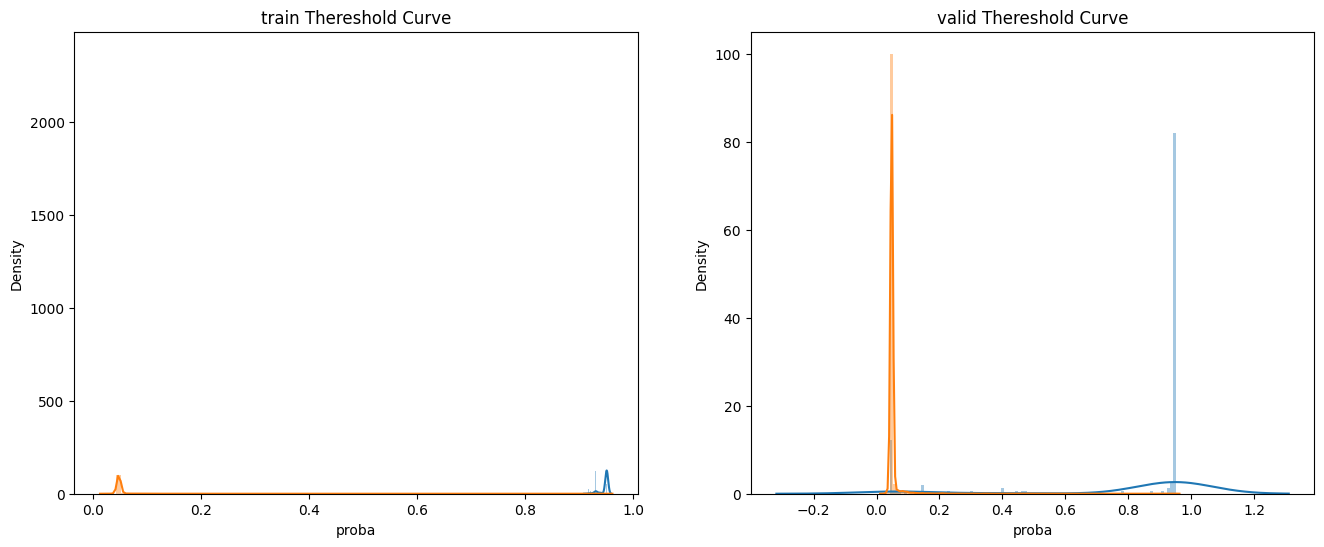

In [11]:
mctao.plot_dist()